In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# Data path for train and test
train_identity_path = '/content/drive/MyDrive/Cozii/ieee-fraud-detection/train_identity.csv'
train_transaction_path = '/content/drive/MyDrive/Cozii/ieee-fraud-detection/train_transaction.csv'

In [ ]:
# Load data
df_train_identity = pd.read_csv(train_identity_path)
df_train_transaction = pd.read_csv(train_transaction_path)

In [ ]:
# Merge on TransactionID using left join (to keep all transactions)
train_df = df_train_transaction.merge(df_train_identity, on="TransactionID", how="left")
del df_train_identity
del df_train_transaction

#1.0 Feature Engineering

In [ ]:
train_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [ ]:
print("Shape of train data :", train_df.shape)

Shape of train data : (590540, 434)


**1.1 Feature Engineering:**
Analyzing time-based spending patterns

In [ ]:
# Check the mac number in 'TransactionDT'
train_df['TransactionDT'].max()

15811131

In [ ]:
'''
TransactionDT first value is 86400
      which corresponds to the number of seconds in a day
      which is 60 * 60 * 24 = 86400

Will add:
      hour - which hour in the day
      weekday - which day of the week
      week - which week of the year
'''
# Convert TransactionDT to meaningful time units
train_df['hour'] = (train_df['TransactionDT'] // 3600) % 24  # Convert seconds to hours
train_df['weekday'] = (train_df['TransactionDT'] // (3600 * 24)) % 7  # Day of the week
train_df['week'] = train_df['TransactionDT'] // (3600 * 24 * 7)  # Week number

In [ ]:
'''
Calculate the transaction count per hour and per week for each user
      user_hourly_txn - transaction count per hour
      user_weekly_txn - transaction count per week
'''

# Count the number of transactions per hour for each user
train_df['user_hourly_txn'] = train_df.groupby(['card1', 'hour'])['TransactionID'].transform('count')
# Count the number of transactions per week for each user
train_df['user_weekly_txn'] = train_df.groupby(['card1', 'week'])['TransactionID'].transform('count')

In [ ]:
'''
Define the Night Time Period (9 PM to 6 AM)
      is_night_txn - Flag for night transactions
'''
# Flag for night transactions (9 PM to 6 AM)
train_df['is_night_txn'] = train_df['hour'].apply(lambda x: 1 if x >= 21 or x < 6 else 0)

In [ ]:
# We add 6 columns to the df
print("Shape of train data :", train_df.shape)

Shape of train data : (590540, 440)


**1.2 Feature Engineering:**
Analyzing frequency




In [ ]:
'''
Fraud transaction tend to make as many transactions as quickly they.
Track spending behavior with:

      Transaction count per user
      Transaction sum
      Transaction standard deviation

Resoning:
      If a user suddenly spends much more than usual, it might be fraud.
      Frequent small transactions in a short period could be fraudsters.
'''

In [ ]:
'''
Transaction count per user
      user_txn_count - transaction count per user
'''
# Number of transactions per user
train_df['user_txn_count'] = train_df.groupby('card1')['TransactionID'].transform('count')

In [ ]:
'''
Transaction sum per user
      user_txn_sum - transaction sum per user
'''
# Total amount spent per user
train_df['user_total_spent'] = train_df.groupby('card1')['TransactionAmt'].transform('sum')

In [ ]:
'''
Transaction standard deviation per user
      user_spent_std - transaction standard deviation per user
'''
# Standard deviation of transaction amount
train_df['user_spent_std'] = train_df.groupby('card1')['TransactionAmt'].transform('std').fillna(0)

In [ ]:
# We add 3 columns to the df
print("Shape of train data :", train_df.shape)

Shape of train data : (590540, 443)


**1.3 Feature Engineering:**
Analyzing transaction location anomalies

In [ ]:
'''
A car used in multiple locations within a short period, it may be compromised.
      Track transactions per region (addr1)
      Detect country changes using P_emaildomain
'''

In [ ]:
'''
Transaction count per region (addr1)
      addr1_txn_count - transaction count per region
'''
# Count transactions per billing address
train_df['addr1_txn_count'] = train_df.groupby('addr1')['TransactionID'].transform('count')

In [ ]:
'''
Check email domain change
      email_domain_change - Flag for email domain change
'''
# Check email domain change
train_df['email_domain_change'] = (train_df.groupby('card1')['P_emaildomain'].transform(lambda x: x.nunique()))

In [ ]:
# We add 2 columns to the df
print("Shape of train data :", train_df.shape)

Shape of train data : (590540, 445)


**1.4 Feature Engineering:**
Analyzing other fraud indicater

In [ ]:
'''
Fraud txn often use some speical numbers ($10, $50, $100).
      is_round_amt -  Flag for round transaction amounts
'''
train_df['is_round_amt'] = train_df['TransactionAmt'].apply(lambda x: 1 if x % 10 == 0 else 0)

In [ ]:
'''
The expiry dates could flag the stolen cards.
      is_uncommon_expiry - Flag for uncommon expiry dates
'''
# Flag for uncommon expiry dates
train_df['is_uncommon_expiry'] = train_df['card5'].apply(lambda x: 1 if x in [200, 300] else 0)

In [ ]:
'''
Device Type change could flag a stolen card.
      device_type_change - Flag for device type change
'''
# Flag for device type change
train_df['device_type_change'] = train_df.groupby('card1')['DeviceInfo'].transform(lambda x: x.nunique())

In [ ]:
'''
IP address change could flag a stolen card.
      ip_address_change_count - Count of IP address changes
'''
# Count of IP address changes
train_df['ip_address_change_count'] = train_df.groupby('card1')['id_30'].transform(lambda x: x.nunique())

In [ ]:
# We add 4 columns to the df
print("Shape of train data :", train_df.shape)

Shape of train data : (590540, 449)


In [ ]:
features_to_keep = ['hour',
                    'weekday',
                    'week',
                    'user_hourly_txn',
                    'user_weekly_txn',
                    'is_night_txn',
                    'user_txn_count',
                    'user_total_spent',
                    'user_spent_std',
                    'addr1_txn_count'
                    'email_domain_change',
                    'is_round_amt',
                    'is_uncommon_expiry',
                    'device_type_change',
                    'ip_address_change_count'
                    ]

#2.0 Handle missing data

In [ ]:
missing_percentage = train_df.isnull().sum() / len(train_df) * 100
missing_percentage

,0
TransactionID,0.0
isFraud,0.0
TransactionDT,0.0
TransactionAmt,0.0
ProductCD,0.0
...,...
email_domain_change,0.0
is_round_amt,0.0
is_uncommon_expiry,0.0
device_type_change,0.0


In [ ]:
# Calculate the percentage of missing values for each column
missing_percentage =train_df.isnull().sum() / len(train_df) * 100

# Set a threshold for the percentage of missing values (set for 15%)
threshold = 15

# Get the columns that exceed the threshold
columns_to_drop = missing_percentage[missing_percentage > threshold].index

# Drop the columns from the DataFrame
train_df = train_df.drop(columns=columns_to_drop)

In [ ]:
print("Shape of train data :", train_df.shape)

Shape of train data : (590540, 175)


In [ ]:
# Visualize missing data pattern
import missingno as msno

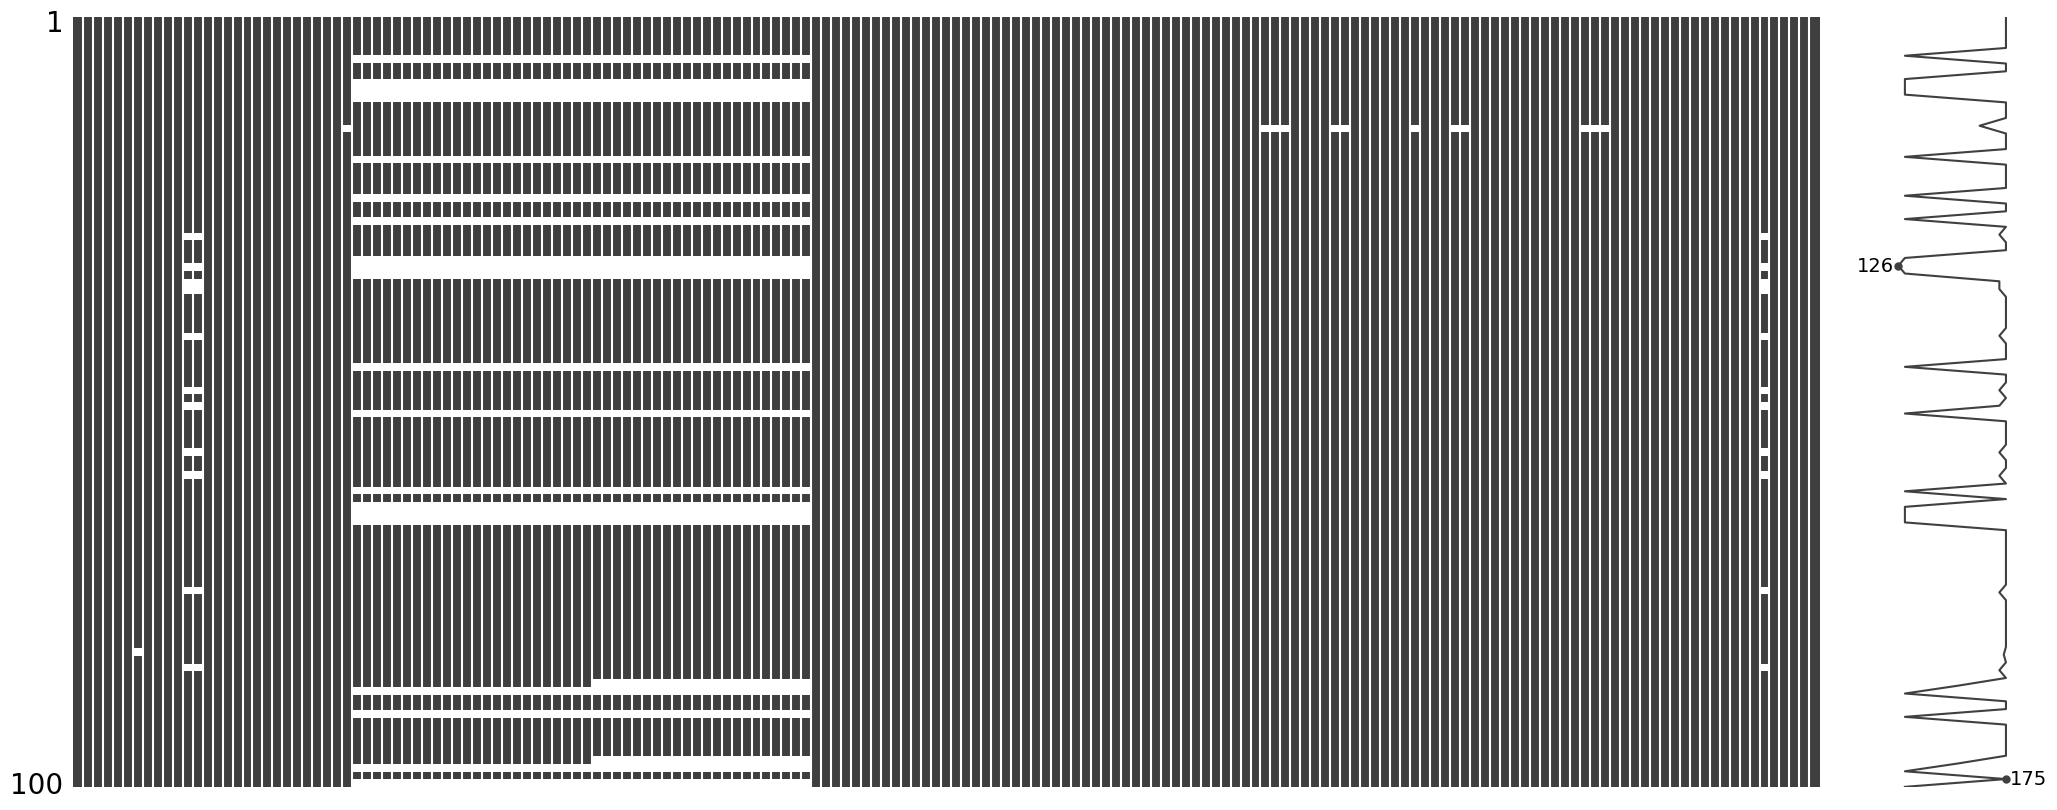

In [ ]:
msno.matrix(train_df.sample(100))
plt.show()

In [ ]:
# Replace NaN with Median value
# Iterate through each column in the DataFrame
for col in train_df.columns:
    # Check if the column is numeric
    if pd.api.types.is_numeric_dtype(train_df[col]):
        # Calculate the median of the column, ignoring NaN values
        median_value = train_df[col].median()

        # Replace NaN values in the column with the median value
        train_df[col].fillna(median_value, inplace=True)


<ipython-input-42-837b7c46c34b>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(median_value, inplace=True)


In [ ]:
# Repalce str with vumerical codes
# Iterate through each column in the DataFrame
for col in train_df.columns:
    # Check if the column's data type is 'object' (categorical)
    if pd.api.types.is_string_dtype(train_df[col]):
        # Convert the column to categorical type
        train_df[col] = pd.Categorical(train_df[col])

        # Convert categorical values to numerical codes
        train_df[col] = train_df[col].cat.codes

In [ ]:
# Find all columns with string data type
str_columns = train_df.select_dtypes(include=['object']).columns

# Apply One-Hot Encoding on those columns
train_df = pd.get_dummies(train_df, columns=str_columns, drop_first=True)

In [ ]:
corr_matrix = train_df.corr().abs()

In [ ]:
# Remove Highly Correlated Features and keep new added features
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9) and column not in features_to_keep]
train_df.drop(columns=to_drop, inplace=True)

In [ ]:
print("Shape of train data :", train_df.shape)

Shape of train data : (590540, 106)


In [ ]:
train_df.head()

,TransactionID,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card5,addr1,addr2,...,addr1_txn_count,email_domain_change,is_round_amt,is_uncommon_expiry,device_type_change,ip_address_change_count,card4_discover,card4_mastercard,card6_credit,card6_debit or credit
0,2987000,0,68.5,4,13926,361.0,150.0,142.0,315.0,87.0,...,23078.0,12,0,0,4,8,True,False,True,False
1,2987001,0,29.0,4,2755,404.0,150.0,102.0,325.0,87.0,...,42751.0,26,0,0,13,17,False,True,True,False
2,2987002,0,59.0,4,4663,490.0,150.0,166.0,330.0,87.0,...,26287.0,15,0,0,5,6,False,False,False,False
3,2987003,0,50.0,4,18132,567.0,150.0,117.0,476.0,87.0,...,9478.0,27,1,0,34,42,False,True,False,False
4,2987004,0,50.0,1,4497,514.0,150.0,102.0,420.0,87.0,...,3581.0,5,1,0,4,3,False,True,True,False


# 3.0 Handle data imbalance



In [ ]:
#Synthetic Minority Over-sampling
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [ ]:
# Define features and target variable
X = train_df.drop(columns=['isFraud'])  # Remove target column
y = train_df['isFraud']  # Target variable

In [ ]:
# Apply SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
print("Before SMOTE:")
print(np.bincount(y))

print("\nAfter SMOTE:")
print(np.bincount(y_resampled))

Before SMOTE:
[569877  20663]

After SMOTE:
[569877 569877]


#4.0 Save preprocessed data

In [ ]:
X_resampled.to_csv("X_resampled.csv", index=False)
y_resampled.to_csv("y_resampled.csv", index=False)

In [ ]:
import pickle

# Save to_drop list
with open("to_drop.pkl", "wb") as f:
    pickle.dump(to_drop, f)

In [ ]:
# Load to_drop
with open("to_drop.pkl", "rb") as f:
    to_drop = pickle.load(f)